In [410]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
% matplotlib inline

In [497]:
### function to generate fake data for a line
def fake_line(N,m,b):
    x = np.sort(10*np.random.rand(N))
    yerr = 2.+1.*np.random.rand(N)
    y = m*x+b
    y += yerr * np.random.randn(N)
    return x, y, yerr

In [435]:
### probabilites here
def lnlike(theta, x, y, yerr):
    m, b = theta[0], theta[1]
    model = m * x + b
    inv_sigma2 = 1.0/yerr**2
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b = theta[0], theta[1]
    if -10.0 < m < 10.0 and -10.0 < b < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [451]:
### M-H MCMC sampler from Problem2
def MHsampler(lnprob, args, start, steps):
    '''
    TO DO: Add doc string
    '''
    x, y, yerr = args
    ndim = len(start)
    chain = np.empty((ndim,steps)) # to store samples
    chain[:,0] = np.asarray(start) # starting point
    prop = np.empty(ndim)
    for i in np.arange(steps-1):
        # draw your next step -- use Uniform distribution as proposal density
        prop[0] = np.random.uniform(chain[:,i][0]-0.5,chain[:,i][0]+0.5)
        prop[1] = np.random.uniform(chain[:,i][1]-0.5,chain[:,i][1]+0.5)
        # acceptance ratio
        lnalpha = lnprob(prop,x,y,yerr)-lnprob(chain[:,i],x,y,yerr)
        #print lnalpha
        # decision time!
        if np.isinf(lnalpha):
            chain[:,i+1] = chain[:,i]
        elif lnalpha >= 0 or np.isnan(lnalpha):
            chain[:,i+1] = prop
        else:
            r = np.random.uniform(0,1)
            while not np.isfinite(r):
                r = np.random.uniform(0,1)
            #print np.log(r)
            if lnalpha >= np.log(r):
                chain[:,i+1] = prop
            elif lnalpha < np.log(r):
                chain[:,i+1] = chain[:,i]
    return chain

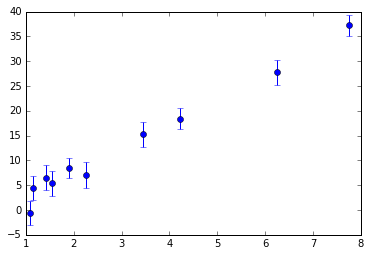

In [498]:
# generate some fake data
N = 10
m = 5
b = -2
x, y, yerr = fake_line(N,m,b)

# plot 
plt.errorbar(x,y,yerr=yerr,fmt='o')
plt.show()

In [453]:
# time to run the sampler
args = (x,y,yerr)
start = (4,0)
steps = 10000
samples = MHsampler(lnprob, args, start=start, steps=steps)

### check acceptance fraction is reasonable
float(np.unique(samples).size/2)/steps

0.3023

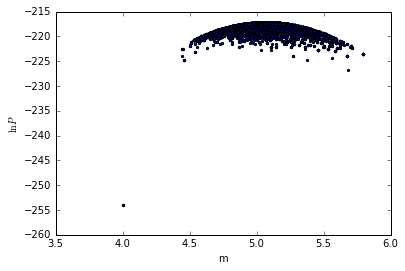

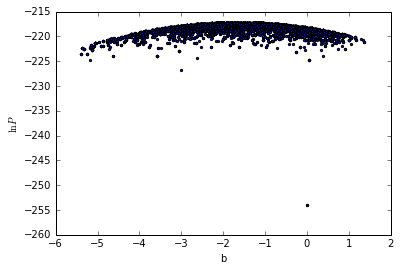

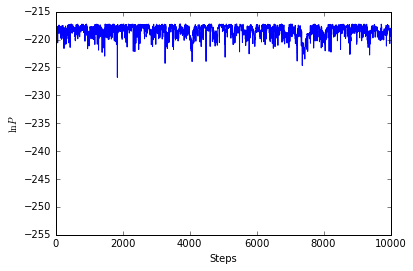

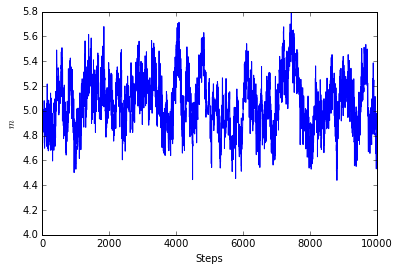

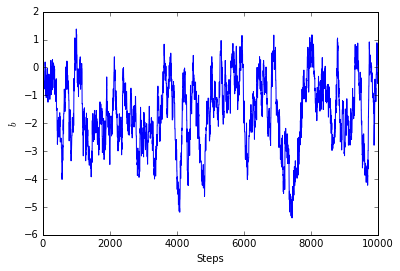

In [454]:
### convergence plots
ms = samples[0,:]
bs = samples[1,:]
lnprobs = [lnprob(samples[:,i],x,y,yerr) for i in xrange(steps)]

plt.scatter(ms, lnprobs ,marker='.')
plt.xlabel(r'm')
plt.ylabel(r'$\ln P$')
plt.show()

plt.scatter(bs, lnprobs ,marker='.')
plt.xlabel(r'b')
plt.ylabel(r'$\ln P$')
plt.show()

plt.plot(np.arange(steps),lnprobs)
plt.xlabel(r'Steps')
plt.ylabel(r'$\ln P$')
plt.show()

plt.plot(np.arange(steps),ms)
plt.xlabel(r'Steps')
plt.ylabel(r'$m$')
plt.show()

plt.plot(np.arange(steps),bs)
plt.xlabel(r'Steps')
plt.ylabel(r'$b$')
plt.show()

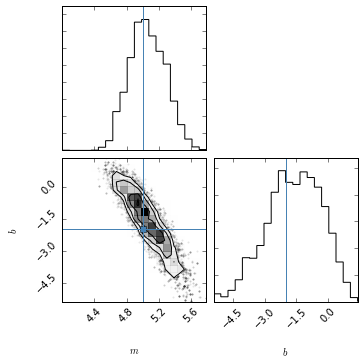

In [455]:
### corner plot here
samples2 = samples.T
fig = corner.corner(samples2, labels=["$m$", "$b$"],
                      truths=[m, b])

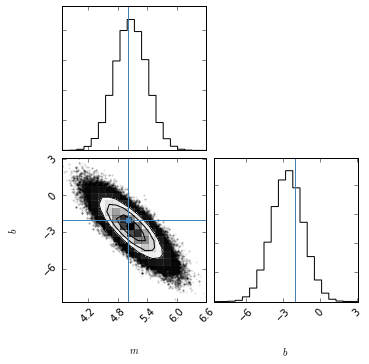

In [499]:
### now use emcee
ndim, nwalkers = 2, 100
pos = [np.array([np.random.uniform(4.5,5.5),np.random.uniform(-2.5,-1.5)]) for i in range(nwalkers)]
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x,y,yerr))
emcee_sampler.run_mcmc(pos, 5000)
emcee_samples = emcee_sampler.chain[:,:, :].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["$m$", "$b$"], truths=[m, b])

<Container object of 3 artists>

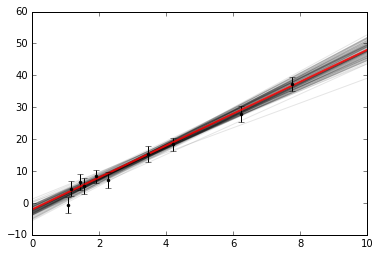

In [500]:
xl = np.array([0, 10])
for m_e, b_e in emcee_samples[np.random.randint(len(emcee_samples), size=100)]:
    plt.plot(xl, m_e*xl+b_e, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")